In [34]:
library(dplyr)
library(limma)
library(ggplot2)
library(ggVennDiagram)
library(readxl)
library(viridis)

Loading required package: viridisLite



In [17]:
# Leer el archivo de datos sin normalizar
expr_file <- "/home/mlopez/Desktop/alzheimer/data/GSE118553/GSE118553_non-normalized_data.txt.gz"
expr_raw <- read.delim(gzfile(expr_file), header = TRUE, stringsAsFactors = FALSE)

In [18]:
# Cargar los metadata
metadata <- read.csv("/home/mlopez/Desktop/alzheimer/results/GSE118553/GSE118553_metadata.csv", stringsAsFactors = FALSE)
rownames(metadata) <- metadata$SampleID

#annotacion de los genes.
annot <- read.delim("/home/mlopez/Desktop/alzheimer/data/GSE118553/GPL10558_HumanHT-12_V4_0_R1_15002873_B.txt.gz",skip=8, stringsAsFactors = FALSE)

In [19]:
annot_sel <- unique(annot[,c("Probe_Id","Symbol")])

expr_raw_annot <- merge(expr_raw, annot_sel, by.x="ID_REF", by.y="Probe_Id")

In [20]:
# Calcular varianza por fila
expr_raw_annot$variance <- apply(expr_raw_annot[, paste("X", metadata$SampleID,sep="")], 1, var)

# Ordenar por símbolo y quedarte con la fila de mayor varianza por símbolo
expr_maxvar <- expr_raw_annot %>%
  dplyr::group_by(Symbol) %>%
  dplyr::slice_max(order_by = variance, n = 1, with_ties = FALSE) %>%
  dplyr::ungroup()

# Ahora puedes poner los símbolos como rownames
expr_matrix <- as.data.frame(expr_maxvar[, paste("X", metadata$SampleID,sep="")])
rownames(expr_matrix) <- expr_maxvar$Symbol
colnames(expr_matrix) <- metadata[gsub("^X","",colnames(expr_matrix)),"Accession"]
expr_matrix <- expr_matrix[rownames(expr_matrix) != "",]

In [21]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE118553/boxplot_raw_expr_GSE118553.pdf", width=20, height=12)
# Boxplot más amplio
par(mar=c(8,4,4,2))  # margenes inferiores más grandes para etiquetas
boxplot(expr_matrix,
        las=2,                    # rotar etiquetas del eje x
        col="lightblue",
        main="Boxplot before normalization",
        cex.axis=0.6)             # reducir tamaño de texto
dev.off()

pdf 
  2

In [22]:
norm_expr <- normalizeBetweenArrays(expr_matrix, method = "quantile")

In [8]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE118553/boxplot_norm_expr_GSE118553.pdf", width=20, height=12)
# Boxplot más amplio
par(mar=c(8,4,4,2))  # margenes inferiores más grandes para etiquetas
boxplot(norm_expr,
        las=2,                    # rotar etiquetas del eje x
        col="lightblue",
        main="Boxplot before normalization",
        cex.axis=0.6)             # reducir tamaño de texto
dev.off()	

pdf 
  2

In [23]:
# Corregir solo las filas con "AsymAD" en BrainRegion
asym_idx <- grepl("AsymAD", metadata$BrainRegion)

# Actualizar el grupo a "AsymAD" solo en esos casos
metadata$Group[asym_idx] <- "AsymAD"

# Limpiar la región cerebral eliminando " AsymAD (...)" al final
metadata$BrainRegion[asym_idx] <- gsub(" AsymAD.*", "", metadata$BrainRegion[asym_idx])
metadata$BrainRegion <- trimws(metadata$BrainRegion)

In [24]:
# Transponer para que las filas sean muestras
pca <- prcomp(t(norm_expr), scale. = TRUE)

pca_df <- as.data.frame(pca$x[, 1:2])  # Primeras 2 PCs
pca_df$SampleID <- rownames(pca_df)
pca_df <- merge(pca_df, metadata, by.x = "SampleID", by.y="Accession")

In [11]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE118553/pca_norm_expr_GSE118553.pdf")
ggplot(pca_df, aes(x = PC1, y = PC2, color = Group, shape = BrainRegion)) +
  geom_point(size = 3, alpha = 0.8) +
  theme_minimal() +
  labs(title = "PCA of Expression Data",
       subtitle = "Colored by AD/Control, shaped by Brain Region",
       x = paste0("PC1 (", round(summary(pca)$importance[2,1] * 100, 1), "%)"),
       y = paste0("PC2 (", round(summary(pca)$importance[2,2] * 100, 1), "%)")) +
  theme(axis.text = element_text(size=10),
        plot.title = element_text(face="bold", size=14),
        legend.title = element_text(size=12))
dev.off()

pdf 
  2

In [25]:
# Filtrar metadata
metadata_filtered <- metadata %>%
  filter(Group %in% c("AD", "CONTROL"))

# Filtrar matriz de expresión
expr_filtered <- norm_expr[, metadata_filtered$Accession]

# Comprobar que el orden coincide
stopifnot(all(colnames(expr_filtered) == metadata_filtered$Accession))

In [26]:
# Lista de regiones únicas
regiones <- unique(metadata_filtered$BrainRegion)

# Crear una lista para guardar resultados
resultados_dge <- list()

for (region in regiones) {
  cat("Procesando región:", region, "\n")
  
  # Filtrar metadata y expresión por región
  meta_region <- metadata_filtered %>% filter(BrainRegion == region)
  expr_region <- expr_filtered[, meta_region$Accession]

  # Crear diseño para limma
  group <- factor(meta_region$Group, levels = c("CONTROL", "AD"))  # CONTROL como referencia
  design <- model.matrix(~ group)
  
  # Ajustar modelo con limma
  fit <- lmFit(expr_region, design)
  fit <- eBayes(fit)
  
  # Obtener resultados
  res <- topTable(fit, coef = "groupAD", number = Inf, adjust = "fdr")
  
  # Guardar resultados
  resultados_dge[[region]] <- res
}

Procesando región: Temporal_Cortex 
Procesando región: Cerebellum 
Procesando región: Frontal_Cortex 
Procesando región: Entorhinal_Cortex 


In [14]:
write.csv(resultados_dge[["Temporal_Cortex"]], file = "/home/mlopez/Desktop/alzheimer/results/GSE118553/dif_expr_results_GSE118553_temporal_cortex.csv", row.names = TRUE)
write.csv(resultados_dge[["Cerebellum"]], file = "/home/mlopez/Desktop/alzheimer/results/GSE118553/dif_expr_results_GSE118553_cerebellum.csv", row.names = TRUE)
write.csv(resultados_dge[["Frontal_Cortex"]], file = "/home/mlopez/Desktop/alzheimer/results/GSE118553/dif_expr_results_GSE118553_frontal_cortex.csv", row.names = TRUE)
write.csv(resultados_dge[["Entorhinal_Cortex"]], file = "/home/mlopez/Desktop/alzheimer/results/GSE118553/dif_expr_results_GSE118553_entorhinal_cortex.csv", row.names = TRUE)

In [27]:
# Extraer genes con adj.P.Val < 0.05
genes_significativos <- lapply(resultados_dge, function(res) {
  rownames(res[res$adj.P.Val < 0.05, ])
})

# Nombres completos de las regiones
names(genes_significativos) <- names(resultados_dge)

pdf("/home/mlopez/Desktop/alzheimer/results/GSE118553/compar_results_zonas_GSE118553.pdf")
ggVennDiagram(genes_significativos, label = "count", label_alpha = 0) +
  scale_fill_gradient(low = "white", high = "white") + 
  theme_void() +
  theme(
    legend.position = "none",  # Oculta la leyenda
    text = element_text(size = 14),
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold")
  ) +
  labs(title = "Genes diferencialmente expresados (adj.P.Val < 0.05)")
dev.off()

pdf 
  2

In [36]:
AD_T4_targets <- read_excel("/home/mlopez/Desktop/alzheimer/data/AD_T4_targets.xlsx")

New names:
• `` -> `...1`


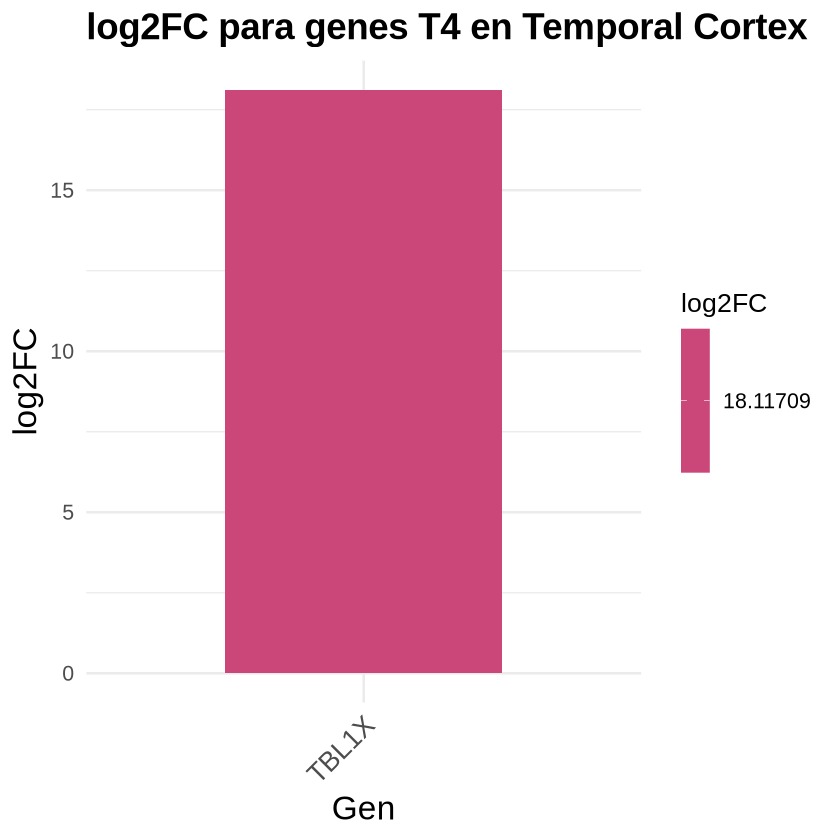

In [49]:
T4_exp_dif_temporal_cortex <- na.omit(resultados_dge[["Temporal_Cortex"]][AD_T4_targets$Prot,])
T4_exp_dif_temporal_cortex_sig <- T4_exp_dif_temporal_cortex[T4_exp_dif_temporal_cortex$adj.P.Val < 0.05,]

T4_exp_dif_temporal_cortex_sig$gene <- rownames(T4_exp_dif_temporal_cortex_sig)

ggplot(T4_exp_dif_temporal_cortex_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "log2FC para genes T4 en Temporal Cortex",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )

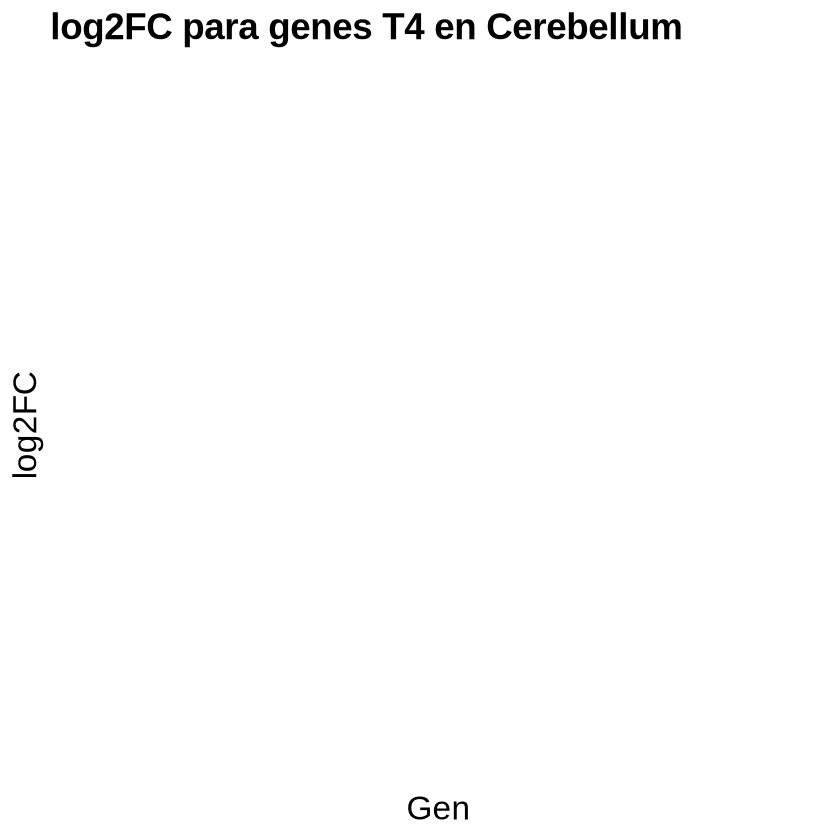

In [51]:
T4_exp_dif_cerebellum <- na.omit(resultados_dge[["Cerebellum"]][AD_T4_targets$Prot,])
T4_exp_dif_cerebellum_sig <- T4_exp_dif_cerebellum[T4_exp_dif_cerebellum$adj.P.Val < 0.05,]

T4_exp_dif_cerebellum_sig$gene <- rownames(T4_exp_dif_cerebellum_sig)

ggplot(T4_exp_dif_cerebellum_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "log2FC para genes T4 en Cerebellum",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )

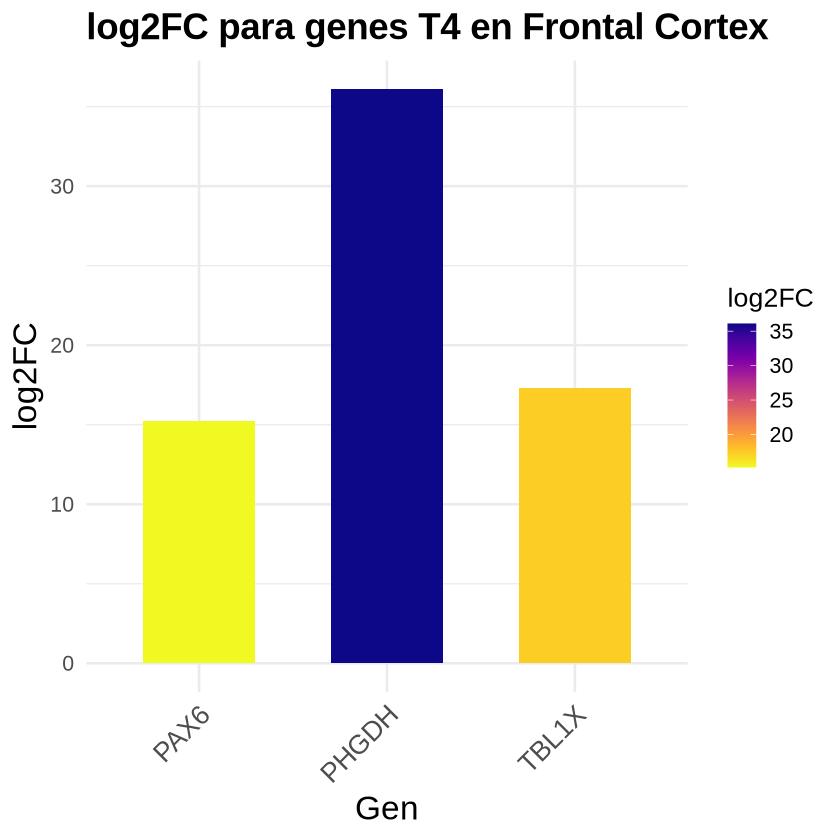

In [52]:
T4_exp_dif_frontal_cortex <- na.omit(resultados_dge[["Frontal_Cortex"]][AD_T4_targets$Prot,])
T4_exp_dif_frontal_cortex_sig <- T4_exp_dif_frontal_cortex[T4_exp_dif_frontal_cortex$adj.P.Val < 0.05,]

T4_exp_dif_frontal_cortex_sig$gene <- rownames(T4_exp_dif_frontal_cortex_sig)

ggplot(T4_exp_dif_frontal_cortex_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "log2FC para genes T4 en Frontal Cortex",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )

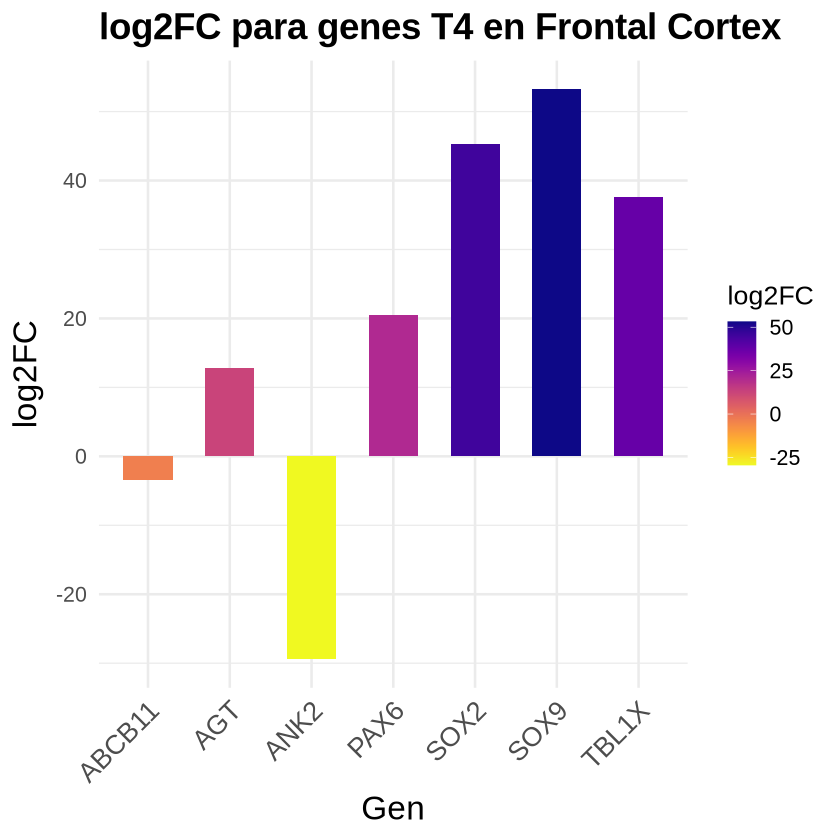

In [53]:
T4_exp_dif_entorhinal_cortex <- na.omit(resultados_dge[["Entorhinal_Cortex"]][AD_T4_targets$Prot,])
T4_exp_dif_entorhinal_cortex_sig <- T4_exp_dif_entorhinal_cortex[T4_exp_dif_entorhinal_cortex$adj.P.Val < 0.05,]

T4_exp_dif_entorhinal_cortex_sig$gene <- rownames(T4_exp_dif_entorhinal_cortex_sig)

ggplot(T4_exp_dif_entorhinal_cortex_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "log2FC para genes T4 en Frontal Cortex",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )